# Monte Carlo Simulation for Portfolio Value at Risk (VaR)
**Author:** Winifred Mei  
**Date:** August 21, 2025  

In this notebook, we estimate **Value at Risk (VaR)** using a **Monte Carlo simulation**.  
We simulate a large number of potential portfolio outcomes over a short-term horizon and calculate risk measures based on these scenarios.


## Import Required Libraries

We begin by importing all the necessary Python libraries:  
- `numpy` and `pandas` for numerical and data operations  
- `datetime` for handling date ranges  
- `yfinance` to download historical stock prices  
- `matplotlib` for visualization  
- `scipy.stats` for statistical functions


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

## Set Time Range and Define Portfolio Tickers

We define the historical period for analysis and select the stocks for our portfolio.


In [3]:
# Analysis period
years_back = 10
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365*years_back)

# Portfolio tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']


In [4]:
price_data = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    price_data[ticker] = data['Close']

# Daily log returns
log_returns = np.log(price_data / price_data.shift(1)).dropna()


/var/folders/fb/yy69flkj2yv4cyv2j0q3jyzw0000gn/T/ipykernel_4440/2582954864.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/fb/yy69flkj2yv4cyv2j0q3jyzw0000gn/T/ipykernel_4440/2582954864.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/fb/yy69flkj2yv4cyv2j0q3jyzw0000gn/T/ipykernel_4440/2582954864.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/fb/yy69flkj2yv4cyv2j0q3jyzw0000gn/T/ipykernel_4440/2582954864.py:4: FutureWarning: YF.download() has changed argument au

## Define Functions for Portfolio Metrics

We create functions to calculate **portfolio expected return** and **portfolio standard deviation**.


In [5]:
def portfolio_expected_return(weights, returns_df):
    return np.sum(returns_df.mean() * weights)

def portfolio_std_dev(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


## Create Covariance Matrix and Portfolio Statistics

We construct a covariance matrix of daily returns and calculate portfolio expected return and standard deviation.


In [6]:
cov_matrix = log_returns.cov()
weights = np.array([1/len(tickers)] * len(tickers))
portfolio_value = 500_000  # total portfolio value

exp_return = portfolio_expected_return(weights, log_returns)
std_dev = portfolio_std_dev(weights, cov_matrix)


## Define Monte Carlo Simulation Functions

We define a function to generate random Z-scores and calculate **scenario gain/loss** for a given day window.


In [7]:
def random_z():
    return np.random.normal(0, 1)

simulation_days = 20

def scenario_gain_loss(portfolio_value, portfolio_std, z_score, days):
    return portfolio_value * exp_return * days + portfolio_value * portfolio_std * z_score * np.sqrt(days)


## Run Monte Carlo Simulations

We run **10,000 simulations** to generate potential portfolio outcomes over the specified horizon.


In [8]:
num_simulations = 10000
simulation_results = []

for _ in range(num_simulations):
    z = random_z()
    simulation_results.append(scenario_gain_loss(portfolio_value, std_dev, z, simulation_days))


## Calculate Value at Risk (VaR)

We calculate **VaR** at a 99% confidence level based on the simulated outcomes.


In [9]:
confidence_level = 0.99
VaR = -np.percentile(simulation_results, 100 * (1 - confidence_level))
print(f"Portfolio VaR at {confidence_level:.0%} confidence level: ${VaR:,.2f}")


Portfolio VaR at 99% confidence level: $82,331.47


## Visualize Simulation Results and VaR

We plot a histogram of simulated portfolio gains and losses, highlighting the VaR threshold.


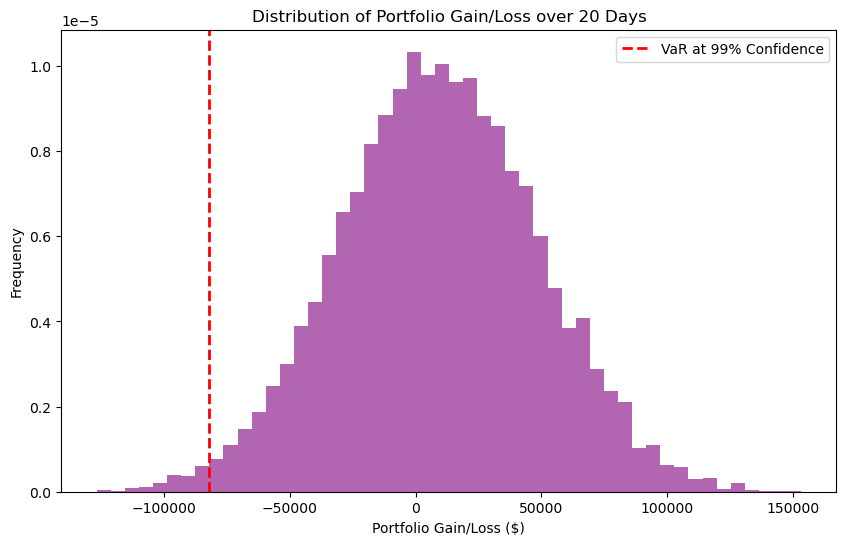

In [10]:
plt.figure(figsize=(10,6))
plt.hist(simulation_results, bins=50, density=True, alpha=0.6, color='purple')
plt.xlabel('Portfolio Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss over {simulation_days} Days')
plt.axvline(-VaR, color='red', linestyle='--', linewidth=2, label=f'VaR at {confidence_level:.0%} Confidence')
plt.legend()
plt.show()
